In [ ]:
!conda install micromamba -y

In [1]:
!micromamba install cartopy pyproj xarray fsspec boto3 h5netcdf s3fs -y


                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

conda-forge/noarch       Using cache
pkgs/main/linux-64       Using cache
pkgs/main/noarch         Using cache
pkgs/r/linux-64          Using cache
pkgs/r/noarch            Using cache
conda-forge/linux-64     [<=>                 ] (00m:00s) 
conda-forge/linux-64     [=>                ] (00m:00s) 524 KB / ?? (3.41 MB/s)
conda-forge/linux-64     [<=>               ] (00m:00s) 524 KB / ?? (3.41 MB/s)
conda-forge/linux-64     [ <=>                ] (00m:00s) 1 MB / ?? (3.65 MB/s)
conda-forge/linux-64     [  <=>               ] (00m:00s) 1 MB / ?? (3.65 MB/s)
conda-forge/linux-64     [  <=>               ] (00m:00s) 2 MB / ?? (4.03 MB/s)
conda-forge/linux-64     [   <=>              ] (00m:00s) 2 MB / ?? (4.03 MB/s)
c

In [2]:
%matplotlib inline
import xarray as xr
import boto3
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cartopy, cartopy.crs as ccrs  

In [3]:
def get_url_for_prefix(prefix):
    s3 = boto3.client("s3")
    paginator = s3.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket = 'noaa-goes16', Prefix = prefix)


    files_mapper = ["s3://noaa-goes16/" + file['Key'] for page in page_iterator for file in page['Contents']]
    return files_mapper[1]

get_url_for_prefix('ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C01')

's3://noaa-goes16/ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C01_G16_s20210011806176_e20210011808549_c20210011809018.nc'

In [4]:
blue_url = get_url_for_prefix('ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C01')
blue_ds = xr.open_dataset(fsspec.open(blue_url).open())
blue_ds

<xarray.Dataset>
Dimensions:                                           (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 5000, y: 3000)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.1282 ... ...
  * x                                                 (x) float32 -0.1013 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_wavelength                                   (band) float32 ...
    band_id                                           (band) int8 ...
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables: (12/35)
    CMI                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    focal_plane_temperature_threshold_exceeded_count  float64 ...
    maximum_focal_plane_temperature                   float32 ...
    focal_plane_temperature_threshold_increasing      float32 ...
    focal_plane_temperature_threshold_decreasing      float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2021-01-01T18:06:17.6Z
    time_coverage_end:         2021-01-01T18:08:54.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        01c42375-da6d-4635-8f1f-7fbf0f4b31f0

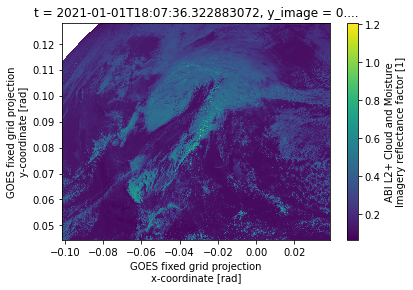

In [5]:
blue_ds['CMI'].plot()

In [6]:
red_url = get_url_for_prefix('ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C02')
red_ds = xr.open_dataset(fsspec.open(red_url).open())
veggie_url = get_url_for_prefix('ABI-L2-CMIPC/2021/001/18/OR_ABI-L2-CMIPC-M6C03')
veggie_ds = xr.open_dataset(fsspec.open(veggie_url).open())

In [7]:
display(red_ds['CMI'].values.shape)
display(veggie_ds['CMI'].values.shape)
display(blue_ds['CMI'].values.shape)

(6000, 10000)

(3000, 5000)

(3000, 5000)

In [8]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [9]:
red_1km = rebin(red_ds['CMI'].values, [3000, 5000])

In [10]:
red_1km.shape

(3000, 5000)

In [11]:
veggie_1km = veggie_ds['CMI'].values
blue_1km = blue_ds['CMI'].values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


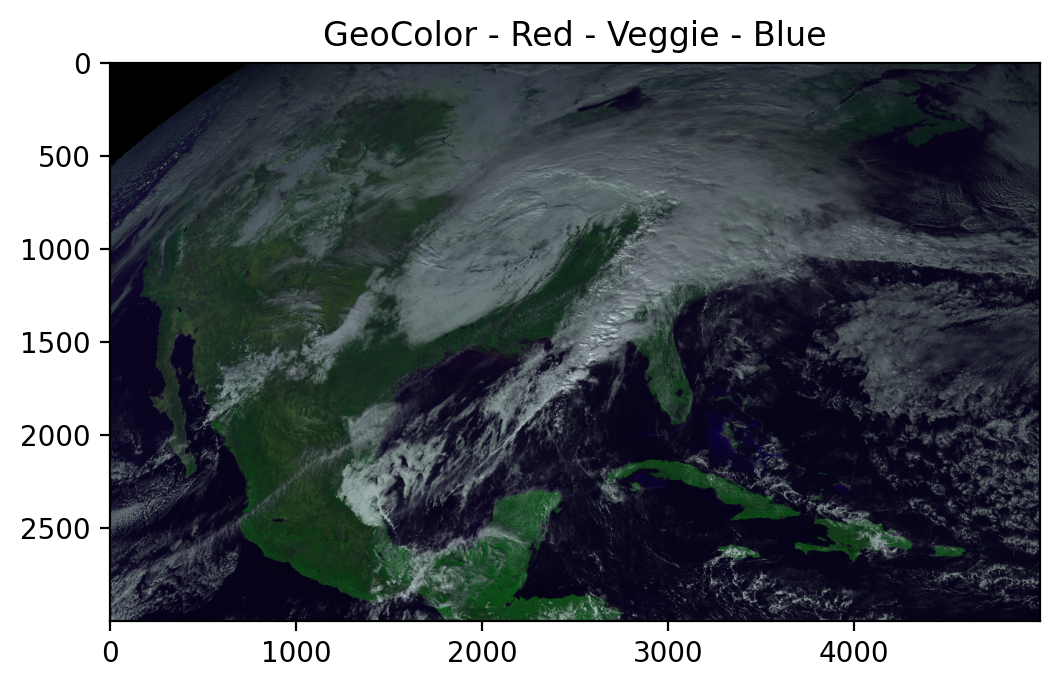

In [12]:
geocolor = np.stack([red_1km, veggie_1km, blue_1km], axis=2)
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(geocolor)
plt.title('GeoColor - Red - Veggie - Blue')
plt.show()

In [13]:
green_1km = 0.48358168 * veggie_1km + 0.45706946 * red_1km + 0.06038137 * blue_1km

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


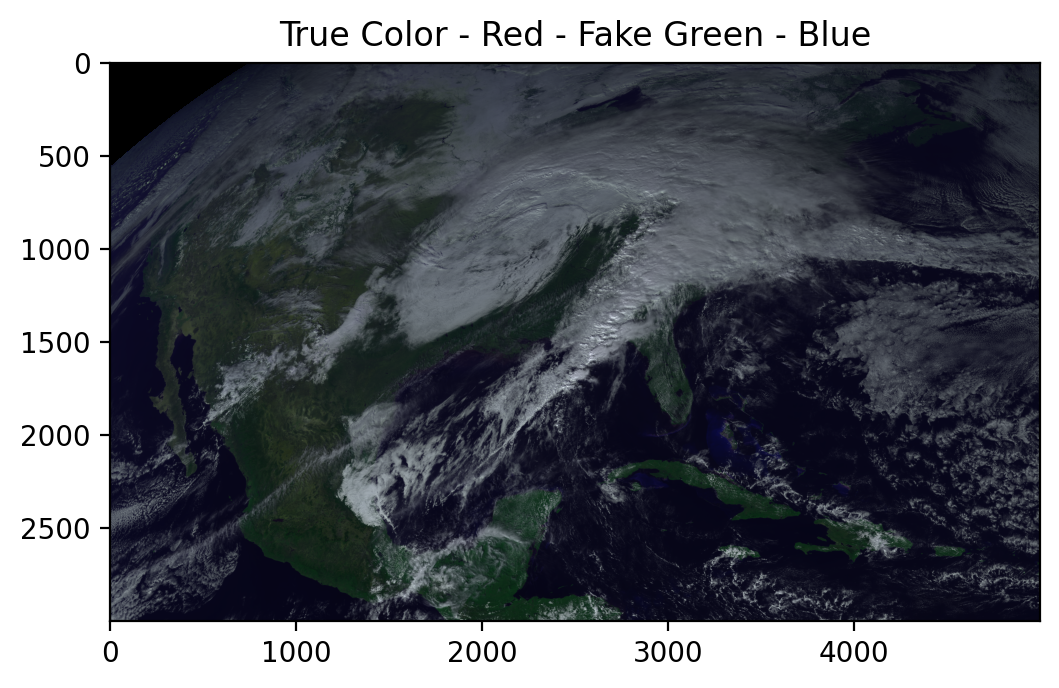

In [14]:
truecolor = np.stack([red_1km, green_1km, blue_1km], axis=2)
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(truecolor)
plt.title('True Color - Red - Fake Green - Blue')
plt.show()